# データセットの実装

- ダウンローダの実装
    - `overwrite=True`でダウンロード&解凍
    - ダウンロード処理
    - 解凍処理
    - TODO: `GoogleDriveDownloader`(MyDriveからコピー)の実装

### Cat2000
- カテゴリごとに抽出できる
    - カテゴリは`List[str]`で指定
    - カテゴリは`trainSet/Stimuli`の配下にあるディレクトリ名


### SALICON
- カテゴリは`["train", "val"]`の2種類
- データはgoogle driveの`/content/MyDrive/dataset/salicon`に配置して使う
- Google Drive(2.4GB)でDLなのでDownloaderでのダウンロード不可...

#### `./dataset/salicon/`配下に配置するもの
- `images.zip` 画像データ
- `maps.zip` サリエンシーマップのデータ

## Dowonloaderの実装

### Downloader

In [ ]:
import os
import zipfile
from logging import Logger, getLogger
from os import makedirs
from os.path import exists
from typing import Callable
from urllib.parse import urlparse
from zipfile import BadZipFile

import requests
from requests import Response
from tqdm.notebook import tqdm

KIB = 2 ** 10


class Downloader:
    def __init__(self,
                 root: str,
                 url: str,
                 redownload: bool = False,
                 reextract: bool = False,
                 zip_filename: str = None,
                 logger: Logger = None):
        self._root = os.path.normpath(root)

        if isinstance(url, Callable):
            self.url = url()
        else:
            self.url = url

        self.zip_filename = zip_filename or os.path.basename(urlparse(self.url).path)  # URLからファイル名を取得
        self.zip_path = os.path.join(self._root, self.zip_filename)
        self.extract_path = os.path.splitext(self.zip_path)[0]
        self.reextract = reextract
        self.redownload = redownload
        self.logger = logger or getLogger(__name__)

    def download(self):
        """データセットをダウンロードする"""
        if self.is_downloaded() and not self.reextract:
            print(f"Dataset already exists at {self.zip_path}, skipping download.")
            return

        if not exists(self.root):
            makedirs(self.root)

        print(f"Downloading dataset from {self.url}...")


        try:
            response = self.request(self.url)
            self.save_response_content(response, self.zip_path)

            print("\nDownload completed.")

        except requests.exceptions.RequestException as e:
            print(f"Error during download: {e}")

        except zipfile.BadZipFile:
            print("Error: Bad zip file.")

    def request(self, url):
        response = requests.get(url, stream=True)
        response.raise_for_status()  # HTTPエラーを確認
        return response

    def save_response_content(self, response: Response, destination, chunk_size: int = 100 * KIB):
        total = int(response.headers.get('content-length', 0))

        with open(destination, "wb") as f:
            with tqdm(total=total, unit='B', unit_scale=True, unit_divisor=1000) as progress_bar:
                for chunk in response.iter_content(chunk_size=chunk_size):
                    if chunk:
                        f.write(chunk)
                        progress_bar.update(len(chunk))

    def extract(self):
        """ZIPファイルを解凍し、重複したルートフォルダがある場合はまとめる"""
        print(f"Unzipping {self.zip_path}...")
        try:
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                # ZIPファイルのトップレベルのフォルダを確認
                top_level_dirs = {os.path.normpath(x).split(os.sep)[0] for x in zip_ref.namelist()}

                if len(top_level_dirs) == 1:
                    # トップレベルに1つのディレクトリだけある場合
                    top_level_dir = next(iter(top_level_dirs))
                    self.extract_path = os.path.join(self._root, top_level_dir)
                    print(f"Extracting into {self.extract_path}...")

                total_files = len(zip_ref.namelist())
                with tqdm(total=total_files, unit='file') as progress:
                    for file in zip_ref.namelist():
                        destination = self._root if len(top_level_dirs) == 1 else self.extract_path
                        zip_ref.extract(file, destination)
                        progress.update(1)
        except BadZipFile:
            print("Error: Bad zip file, extraction failed.")

        print(f"Extracted to {self._root}.")

    @property
    def root(self):
        return self._root

    def is_downloaded(self):
        return os.path.exists(self.zip_path)

    def is_extracted(self):
        return os.path.exists(self.extract_path)

    def __call__(self, on_complete: Callable = None):
        """ダウンロードを実行する"""
        if self.redownload or not self.is_downloaded():
            print("Downloading...")
            self.download()
        else:
            print(f"Dataset already exists at {self.zip_path}, skipping download.")

        if self.reextract or not self.is_extracted():
            print("Extracting...")
            self.extract()
        else:
            print(f"Dataset already extracted at {self.extract_path}, skipping extraction.")

        if on_complete is not None:
            on_complete()

### GoogleDriveDownloader

In [ ]:
import gdown
from os.path import exists

class GoogleDriveDownloader(Downloader):
    def __init__(self,
                 root: str,
                 file_id: str,
                 redownload: bool = False,
                 reextract: bool = False,
                 zip_filename: str = None,
                 logger: Logger = None):
        url = f"https://drive.google.com/uc?export=download&id={file_id}"
        super().__init__(root, url, redownload, reextract, zip_filename, logger)

    def download(self):
        """Google Driveからデータセットをダウンロードする"""
        if self.is_downloaded() and not self.reextract:
            print(f"Dataset already exists at {self.zip_path}, skipping download.")
            return

        print(f"Downloading dataset from Google Drive file ID {self.url.split('=')[-1]}...")

        if not exists(self.root):
            makedirs(self.root)

        try:
            gdown.download(self.url, self.zip_path, quiet=False)
            print("\nDownload completed.")

        except Exception as e:
            print(f"Error during download: {e}")

## Datasetの実装

### Cat2000

In [ ]:
import glob
from os import path
from typing import Optional, Callable
from PIL import Image
from torch.utils.data import Dataset
import random

class Cat2000Dataset(Dataset):

    URL = "http://saliency.mit.edu/trainSet.zip"

    def __init__(self,
                 root: str = "/content/data",
                 categories: Optional[list[str]] = None,
                 image_transform: Optional[Callable] = None,
                 map_transform: Optional[Callable] = None,
                 ):

        if categories is None:
            categories = ["*"]

        self.categories = categories
        self.image_transform = image_transform
        self.map_transform = map_transform
        self.downloader = Downloader(root=f"{root}/cat2000", url=self.URL)

        self.image_map_pair_cache = []
        self.cache_image_map_paths_cashed = False
        self.downloader(on_complete=self.cache_image_map_paths)


    def cache_image_map_paths(self):
        if self.cache_image_map_paths_cashed:
            return

        dataset_path = path.join(self.downloader.extract_path, "Stimuli")

        # categoriesにワイルドカードが含まれている場合、全カテゴリディレクトリを展開
        if "*" in self.categories:
            expanded_categories = [d for d in glob.glob(os.path.join(dataset_path, "*")) if os.path.isdir(d)]
        else:
            expanded_categories = [os.path.join(dataset_path, category) for category in self.categories]

        expanded_categories.sort()

        for category in expanded_categories:
            category_path = path.join(dataset_path, category)
            images_path_list = glob.glob(path.join(category_path, "*.jpg"))
            maps_path_list = glob.glob(path.join(category_path, "Output", "*.jpg"))

            images_path_list.sort()
            maps_path_list.sort()

            # ペアリング
            for img_path, map_path in zip(images_path_list, maps_path_list):
                self.image_map_pair_cache.append((img_path, map_path))

    def __len__(self):
        return len(self.image_map_pair_cache)

    def __getitem__(self, idx: int):
        image_path, map_path = self.image_map_pair_cache[idx]
        image = Image.open(image_path).convert("RGB")
        map_image = Image.open(map_path).convert("RGB")



        if self.image_transform is not None:
            image = self.image_transform(image)

            if self.map_transform is not None:
                map_image = self.map_transform(map_image)
            else:
                map_image = self.image_transform(map_image)

        return image, map_image

    def __str__(self):
        return "\n".join(
            f"image: {Image.open(pair[0]).size}, map: {Image.open(pair[1]).size}" for pair in self.image_map_pair_cache)


### SALICON

In [ ]:
import glob
from os import path
from typing import Optional, Callable

from PIL import Image
from torch.utils.data import Dataset
from google.colab import drive

from google.colab import drive
import shutil


class SALICONDataset(Dataset):
    IMAGE_ID = r"16RKP-gtuZrbA_L5zLDjO-Fxke_9dIpB3"
    MAPS_ID = r"16OlRr5sfLFrw322Hqadi9E4oKXWPjriw"


    def __init__(self,
                 root: str,
                 categories = None,
                 image_transform: Optional[Callable] = None,
                 map_transform: Optional[Callable] = None
                 ):

        self.categories = categories or ["test", "train"]

        self.image_transform = image_transform
        self.map_transform = map_transform

        source_path = "/content/drive/MyDrive/dataset/salicon" # Google Drive内のファイルやフォルダのパス
        destination_path = "/content/sample_data/salicon"    # ローカルの保存先パス    # ローカルの保存先パス

        destination_path = f"{root}/salicon"

        self.d1 = GoogleDriveDownloader(destination_path, self.IMAGE_ID, zip_filename="images.zip")
        self.d2 = GoogleDriveDownloader(destination_path, self.MAPS_ID, zip_filename="maps.zip")

        self.d1()
        self.d2()

        self.cache_image_map_paths_cashed = False

        # 画像とマップのペアを取得
        self.image_map_pair_cache = []
        self.cache_image_map_paths()

    def cache_image_map_paths(self):
        if self.cache_image_map_paths_cashed:
            return

        for category in self.categories:
            images_dir = self.d1.extract_path
            maps_dir = self.d2.extract_path

            images_path_list = sorted(glob.glob(path.join(images_dir, category, "*.jpg")))
            maps_path_list = sorted(glob.glob(path.join(maps_dir, category, "*.png")))

            # ペアリング
            for img_path, map_path in zip(images_path_list, maps_path_list):
                if path.basename(img_path) == path.basename(map_path).replace(".png", ".jpg"):
                    self.image_map_pair_cache.append((img_path, map_path))

    def __len__(self):
        return len(self.image_map_pair_cache)

    def __getitem__(self, index: int):
        image_path, map_path = self.image_map_pair_cache[index]

        image = Image.open(image_path).convert("RGB")
        map_image = Image.open(map_path).convert("RGB")

        if self.image_transform is not None:
            image = self.image_transform(image)

            if self.map_transform is not None:
                map_image = self.map_transform(map_image)
            else:
                map_image = self.image_transform(map_image)

        return image, map_image

    def __str__(self):
        return "\n".join(
            f"image: {Image.open(pair[0]).size}, map: {Image.open(pair[1]).size}" for pair in self.image_map_pair_cache)


## `torch.utils.data.DataLoader`を使ってデータセットの内容表示

In [ ]:
import matplotlib.pyplot as plt

def show_image(dataloader, num_images):
    for index, (images, maps) in enumerate(dataloader):
        if index >= num_images:
            break

        # 画像の表示
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())  # PyTorchのTensorからNumPyに変換
        plt.title("Image")
        plt.axis('off')

        # サリエンシーマップの表示
        plt.subplot(1, 2, 2)
        plt.imshow(maps[0].permute(1, 2, 0).cpu().numpy())  # PyTorchのTensorからNumPyに変換
        plt.title("Saliency Map")
        plt.axis('off')

        plt.show()

        # 情報の表示
        print("-" * 40)
        print(f"Batch size: {images.size(0)}")  # バッチサイズの確認
        print(f"Image size: {images[0].size()}")  # 画像のサイズ
        print(f"Map size: {maps[0].size()}")  # サリエンシーマップのサイズ
        print("-" * 40)
        print("\n" * 2)


### CAT2000

Downloading...


100%|██████████| 692M/692M [05:17<00:00, 2.18MB/s]



Download completed.
Extracting...
Unzipping /content/data/cat2000/trainSet.zip...
Extracting into /content/data/cat2000/trainSet...


100%|██████████| 8085/8085 [00:05<00:00, 1504.41file/s]


Extracted to /content/data/cat2000.


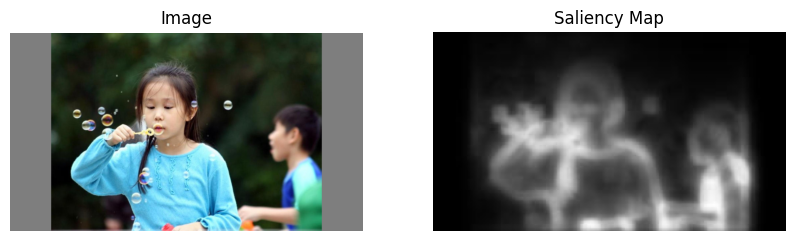

----------------------------------------
Batch size: 4
Image size: torch.Size([3, 1080, 1920])
Map size: torch.Size([3, 141, 250])
----------------------------------------





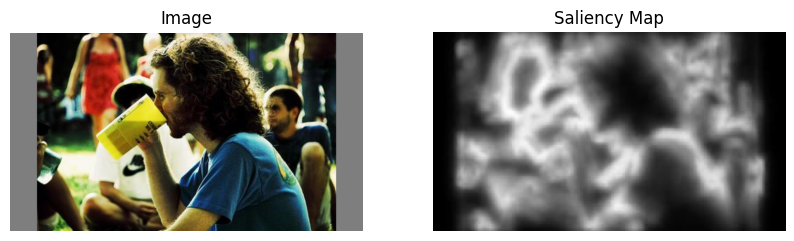

----------------------------------------
Batch size: 4
Image size: torch.Size([3, 1080, 1920])
Map size: torch.Size([3, 141, 250])
----------------------------------------





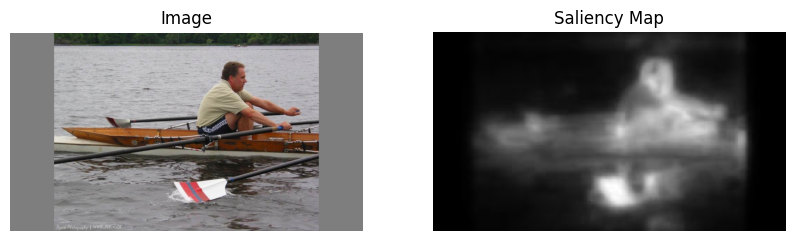

----------------------------------------
Batch size: 4
Image size: torch.Size([3, 1080, 1920])
Map size: torch.Size([3, 141, 250])
----------------------------------------





In [ ]:
from ast import arguments
from torch.utils.data import DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
from tqdm import tqdm

transform_modules = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((144, 256)),
])


dataset = Cat2000Dataset(image_transform=transform_modules)

dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

show_image(dataloader, 3)


### SALICON

In [ ]:
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor
from matplotlib import pyplot as plt
from tqdm import tqdm

transform_modules = Compose([
    ToTensor(),
])

map_transform_modules = Compose([
    ToTensor(),
])

dataset = SALICONDataset("/content/data",image_transform=transform_modules)

dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

show_image(dataloader, 3)


Downloading...
Error during download: [Errno 2] No such file or directory: '/content/data/salicon'
Extracting...
Unzipping /content/data/salicon/images.zip...


FileNotFoundError: [Errno 2] No such file or directory: '/content/data/salicon/images.zip'

# モデルの実装

## ImageShapeAdjuster
- 画像の形を正方形にパディングするためのモジュール
- `Generator`の入力でパディング、出力でクロップしている

In [ ]:
from torch.nn import Module
from torch.nn.functional import pad
from torch import Tensor


class ImageShapeAdjuster(Module):
    def __init__(self):
        super(ImageShapeAdjuster, self).__init__()
        self.padding_size_lrtb = (0, 0, 0, 0)  # デフォルトのパディングサイズ

    def forward(self, target: Tensor):
        return self.pad(target)

    def pad(self, target: Tensor):
        self.padding_size_lrtb = self.get_padding_size(target)
        return pad(target, self.padding_size_lrtb)  # パディング関数を変更

    def crop(self, target: Tensor):
        # 保存された `padding_size` を使ってクロップ
        left, right, top, bottom = self.padding_size_lrtb
        height, width = target.shape[2], target.shape[3]

        return target[:, :, top:height - bottom, left:width - right]

    def get_padding_size(self, target: Tensor):
        height, width = target.shape[2], target.shape[3]

        if height > width:
            left = (height - width) // 2
            right = height - width - left
            top, bottom = 0, 0
        else:
            top = (width - height) // 2
            bottom = width - height - top
            left, right = 0, 0

        return left, right, top, bottom

## UNet

In [ ]:
from torch.nn import Module, Tanh, Sequential, LeakyReLU, Conv2d, ConvTranspose2d, MaxPool2d, BatchNorm2d, Dropout2d, Dropout, Upsample
from torch.nn.functional import interpolate
from torch import Tensor

class Encoder(Module):
    def __init__(self, in_channels=3, out_channels=64, dropout_prob=0.1):
        super(Encoder, self).__init__()

        self.encoder = Sequential(
            Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            MaxPool2d(2, 2),
            BatchNorm2d(out_channels),
            LeakyReLU(0.2),
            Dropout2d(dropout_prob),
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(Module):
    def __init__(self, in_channels=64, out_channels=3, use_skip_connection=True, dropout_prob=0):
        super(Decoder, self).__init__()

        self.use_skip_connection = use_skip_connection

        self.decoder = Sequential(
            ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            LeakyReLU(0.2),
            BatchNorm2d(out_channels),
            Dropout2d(dropout_prob),
        )

    def forward(self, x):
        return self.decoder(x)

    def skip_connection(self, x, y):
        if not self.use_skip_connection:
            return self.forward(x)

        y = interpolate(y, size=x.shape[2:], mode='bilinear', align_corners=True)

        return self.forward(x + y)

class Bottleneck(Module):
    def __init__(self, channels=512, dropout_prob=0.3):
        super(Bottleneck, self).__init__()

        self.bottleneck = Sequential(
            Conv2d(channels, channels, 4, 2, 1),
            BatchNorm2d(channels),
            LeakyReLU(),
            Dropout(dropout_prob),
            )

    def forward(self, x):
        return self.bottleneck(x)

class UNet(Module):
    def __init__(self, in_channels=3, out_channels=1, use_skip_connection=True):
        super(UNet, self).__init__()
        self.use_skip_connection = use_skip_connection

        self.adjuster = ImageShapeAdjuster()

        self.encoder_in_32 = Encoder(in_channels, 32)
        self.encoder_32_64 = Encoder(32, 64)
        self.encoder_64_128 = Encoder(64, 128)
        self.encoder_128_256 = Encoder(128, 256)
        self.encoder_256_512 = Encoder(256, 512)

        self.bottleneck = Bottleneck()

        self.decoder_512_512 = Decoder(512, 512, use_skip_connection)
        self.decoder_512_256 = Decoder(512, 256, use_skip_connection)
        self.decoder_256_128 = Decoder(256, 128, use_skip_connection)
        self.decoder_128_64 = Decoder(128, 64, use_skip_connection)
        self.decoder_64_32 = Decoder(64, 32, use_skip_connection)
        self.decoder_32_out = Decoder(32, out_channels, use_skip_connection)

        self.output = Tanh()

    def forward(self, x):
        adjsuted = self.adjuster.pad(x)

        # var name is "{layer}_{output_ch}"
        enc_32 = self.encoder_in_32(adjsuted)
        enc_64 = self.encoder_32_64(enc_32)
        enc_128 = self.encoder_64_128(enc_64)
        enc_256 = self.encoder_128_256(enc_128)
        enc_512 = self.encoder_256_512(enc_256)

        bottle_512 = self.bottleneck(enc_512)

        dec_512 = self.decoder_512_512(bottle_512)
        dec_256 = self.decoder_512_256.skip_connection(dec_512, bottle_512)
        dec_128 = self.decoder_256_128.skip_connection(dec_256, enc_256)
        dec_64 = self.decoder_128_64.skip_connection(dec_128, enc_128)
        dec_32 = self.decoder_64_32.skip_connection(dec_64, enc_64)
        dec_out = self.decoder_32_out.skip_connection(dec_32, enc_32)

        output = self.output(dec_out)

        return self.adjuster.crop(output)

    def generate(self, image):
        self.eval()
        with torch.no_grad():
            return self.forward(image)


## 出力サイズテスト(UNet)

In [ ]:
from matplotlib import pyplot as plt
import torch

image_height = 216
image_width = 384
image_size = (image_height, image_width)

test_g = UNet(use_skip_connection=True)
test_input = torch.randn(1, 3, image_height, image_width)
test_output = test_g(test_input).detach()

imageAjuster = ImageShapeAdjuster()

test_adjusted = imageAjuster.pad(test_input)
test_cropped = imageAjuster.crop(test_adjusted)

encoder = Encoder()
enc_out = encoder(torch.randn(1,3,256, 256))

print(f"encoder: {enc_out.shape}")
print(f"input: {test_input.shape}")
print(f"output: {test_output.shape}")

plt.imshow(test_input[0].permute(1, 2, 0))
plt.axis("off")
plt.show()

plt.imshow(test_adjusted[0].permute(1, 2, 0))
plt.axis("off")
plt.show()

plt.imshow(test_cropped[0].permute(1, 2, 0))
plt.axis("off")
plt.show()

plt.imshow(test_output[0].permute(1, 2, 0), "gray")
plt.axis("off")
plt.show()

# 学習と評価
- AAAパターンで流れをパターン化
    - `# arrange`: モデルや損失関数、オプティマイザの準備
    - `# act`: トレーニングループ or `fit`関数の実行
    - `# assert`: トレーニング結果の保存、グラフ化

## U-Netの学習

#### TODO:
- トレーニングループ内で`pandas.DataFrame`
- SALICONでの学習と評価
- **`# assertの実装`**
    - matplotlib でプロット
    - `pandas.DataFrame`でCSVを保存
    
- `fit()`関数の実装(トレーニングループを移植)
- `train_generator()`関数の実装(`Generator`1エポック分の学習)
- `train_discriminator()`関数の実装(`Discriminator`1エポック分の学習)
- `fit_gan()`関数の実装(GAN用のトレーニングループ)

### 共通の関数

#### ユーティリティ関数

In [ ]:
import torch
from os import path, makedirs
from datetime import datetime

def save_model(model, root, model_name):
    if not path.exists(root):
        makedirs(root)

    model_path = f"{root}/{model_name}.pth"
    torch.save(model, model_path)
    print(f"Model saved to {model_path}")

def get_timestamp(format="%Y/%m/%d/%H"):
    return datetime.now().strftime(format)

def visualize_batch_results(model, dataloader, device, figsize=(15, 5), save_dir=None):
    model.eval()  # モデルを評価モードに設定
    with torch.no_grad():
        image, salmap = next(iter(dataloader))

        # モデルの出力を取得
        output = model(image.to(device)).detach().cpu()
        output = (output + 1) / 2
        image = (image + 1) / 2
        salmap = (salmap + 1) / 2

        # 保存ディレクトリが指定されている場合は作成
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)

        # バッチ内の各画像を処理
        for i in range(len(image)):
            plt.figure(figsize=figsize)

            # 入力画像
            plt.subplot(1, 3, 1)
            plt.imshow(image[i].permute(1, 2, 0))
            plt.title("input")
            plt.axis("off")

            # ターゲット（サリエンシーマップ）
            plt.subplot(1, 3, 2)
            plt.imshow(salmap[i].permute(1, 2, 0), "gray")
            plt.title("target")
            plt.axis("off")

            # 出力結果
            plt.subplot(1, 3, 3)
            plt.imshow(output[i].permute(1, 2, 0), "gray")
            plt.title("output")
            plt.axis("off")

            # 保存または表示
            if save_dir:
                save_path = os.path.join(save_dir, f"result_{i}.png")
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
                print(f"Result {i} saved to {save_path}")

            plt.show()
            plt.close()



def choose_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def load_model(model_path):
    """
    指定したパスからモデルをロードする関数。
    モデルの重みが存在しない場合は、エラーをキャッチしてNoneを返す。
    """
    try:
        return torch.load(model_path, weights_only=True)
    except AttributeError as e:
        print(f"Error loading model: {e}. Please ensure UNet class is defined and accessible.")
        return None


def choose_model(root, model_name, retraining=True):
    """
    モデルを選択・ロードする関数。
    retraining=Trueかつ指定パスにモデルファイルがある場合にモデルをロードし、
    それ以外の場合は新しいUNetインスタンスを作成。
    """

    if not retraining:
        return UNet()

    model_path = path.join(root, f"{model_name}.pth")

    # モデルが存在し、再トレーニングの設定がされている場合は既存モデルをロード
    if path.exists(model_path):
        unet = load_model(model_path)

        if unet is not None:  # ロードに失敗した場合は新規インスタンスを返す
            return unet

    return UNet()

#### 学習率のプロット

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def save_report(report, root, timestamp, model_name):
    save_path = f"{root}/{timestamp}"

    if not path.exists(save_path):
        makedirs(save_path)

    for itaration in range(len(report)):
        report[itaration]["iteration"] = itaration

    dataframe = pd.DataFrame(report)

    report_path = f"{save_path}/{model_name}.csv"
    dataframe.to_csv(report_path, index=False)

def plot_over_batches(train_report, figsize=(5, 3)):
    # Assuming train_report is a list of dictionaries as in your provided code
    # Create a pandas DataFrame from the train_report list
    df = pd.DataFrame(train_report)

    # Group data by epoch
    grouped = df.groupby('epoch')

    # Plotting
    plt.figure(figsize=figsize)  # Use the provided figsize argument

    for epoch, group_df in grouped:
        plt.plot(group_df['batch'], group_df['loss'], label=f'Epoch {epoch}')

    plt.xlabel('Batch Index')
    plt.ylabel('Loss')
    plt.title('Training Loss over Batches')
    plt.legend()
    plt.grid(True)
    plt.show()



def plot_over_iterations(train_report, figsize=(5, 3)):
    # y_dataとx_dataのリストを初期化
    y_data = []
    x_data = []

    # train_reportの各レポートを順番に処理
    for iterate, report in enumerate(train_report):
        # "loss"がレポートに存在するか確認してから追加
        if "loss" in report:
            y_data.append(report["loss"])
            x_data.append(iterate)

    # x軸とy軸のデータを設定
    x = x_data
    y = y_data

    # プロット
    plt.figure(figsize=figsize)  # Use the provided figsize argument
    plt.plot(x, y)
    plt.xlabel("Iteration")  # 横軸のラベル
    plt.ylabel("Loss")  # 縦軸のラベル
    plt.title("Loss over Iterations")  # グラフのタイトル
    plt.grid(True)  # グリッドを表示
    plt.show()

#### 評価関数

In [ ]:
def normalize01(tensor):
    return (tensor + 1) / 2

def eval_jaccard_index(saliency_map, ground_truth, threshold=0.05):
    saliency_map = normalize01(saliency_map)
    ground_truth = normalize01(ground_truth)
    intersection = torch.logical_and(saliency_map >= threshold, ground_truth >= threshold).sum()
    union = torch.logical_or(saliency_map >= threshold, ground_truth >= threshold).sum()
    return intersection / union


def eval_pixel_wise_accuracy(saliency_map, ground_truth, threshold=0.1):
    saliency_map = normalize01(saliency_map)
    ground_truth = normalize01(ground_truth)
    pixel_errors = torch.abs(saliency_map - ground_truth)

    correct_pixels = pixel_errors <= threshold

    accuracy = correct_pixels.float().mean()

    return accuracy

### トレーニング(U-Net)

In [ ]:
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
from os import path, makedirs
from datetime import datetime
from pandas import DataFrame
from progressbar import progressbar
from torch.nn.functional import l1_loss



def train(model, dataloader, criterion, optimizer, device, batch_stride=3):
    model._train()  # モデルをトレーニングモードに設定
    training_report = []
    total_loss = 0
    max_loss = float("-inf")
    min_loss = float("inf")

    for batch_idx ,(image, salmap) in enumerate(dataloader):
        image = image.to(device)
        salmap = salmap.to(device)

        optimizer.zero_grad()

        outputs = model(image)
        loss = criterion(outputs, salmap)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        accuracy = eval_pixel_wise_accuracy(outputs.detach().clone().reshape(-1), salmap.detach().clone().reshape(-1))

        avg_loss = total_loss / (batch_idx + 1)

        if loss.item() > max_loss:
            max_loss = loss.item()
        if loss.item() < min_loss:
            min_loss = loss.item()

        error_range = max_loss - min_loss
        jaccard_index = eval_jaccard_index(outputs.detach().clone(), salmap.detach().clone())
        accuracy = eval_pixel_wise_accuracy(outputs.detach().clone(), salmap.detach().clone())

        training_report.append({
            "batch": batch_idx,
            "loss": loss.item(),
            "avg_loss": avg_loss,
            "min_loss": min_loss,
            "max_loss": max_loss,
            "pixel_wise_accuracy:": accuracy.item(),
            "error_range": error_range,
            "jaccard_index": jaccard_index.item(),
        })


        if batch_idx % batch_stride == 0:
            print(f"batch: {batch_idx:>5}/{len(dataloader):<5} ({batch_idx/len(dataloader):5.2%})",
                  f"loss: {loss.item():>9.4f}",
                  f"avg loss: {avg_loss:>9.4f}",
                  f"error range: {error_range:>9.4f}",
                  f"output: [min: {outputs.min():>9.4f},\t max:{outputs.max():>8.4f}]",
                  f"Pixel-wise accuracy: {accuracy.item():>5.2%}",
                  f"Jaccard index: {jaccard_index.item():>5.2%}",
                  sep="\t")

    average_loss = total_loss / len(dataloader)
    print(f"average loss: {average_loss:>9.4f}")
    print(f"max loss: {max_loss:>9.4f} min loss: {min_loss:>9.4f}")

    print()

    return training_report # [{"batch":batch_idx, "loss":loss, "accuracy":accuracy}]

def test(model, dataloader, criterion, device, batch_stride=2):
    model.eval()
    total_loss = 0
    total_jaccard_index = []
    total_accuracy = []

    with torch.no_grad():
        for batch_idx, (image, salmap) in enumerate(dataloader):
            image = image.to(device)
            salmap = salmap.to(device)

            outputs = model(image)
            loss = criterion(outputs, salmap)
            total_loss += loss.item()

            accuracy = eval_pixel_wise_accuracy(outputs.detach().clone().reshape(-1), salmap.detach().clone().reshape(-1))
            jaccard_index = eval_jaccard_index(outputs.detach().clone(), salmap.detach().clone())

            total_accuracy.append(accuracy.item())
            total_jaccard_index.append(jaccard_index.item())

            if batch_idx % batch_stride == 0:
                avg_loss = total_loss / (batch_idx + 1)

                print(f"batch: {batch_idx:>5}/{len(dataloader):<5} ({batch_idx/len(dataloader):>5.2%})",
                    f"loss: {loss:9.4f}",
                    f"avg loss: {avg_loss:9.4f}",
                    f"pixel wise accuracy: {accuracy:>5.2%}",
                    f"jaccard index {jaccard_index:>5.2%}",
                    sep="\t")

    avg_jaccard_index = sum(total_jaccard_index) / len(total_jaccard_index)
    avg_accuracy = sum(total_accuracy) / len(total_accuracy)
    average_loss = total_loss / len(dataloader)

    print(f"average loss: {average_loss:>9.4f}")
    print(f"average jaccard index: {avg_jaccard_index:>5.2%}")
    print(f"average accuracy: {avg_accuracy:>5.2%}")
    return average_loss


def fit(model, train_dataloader, test_dataloader, criterion, optimizer, epochs, device, root):
    """
    トレーニングを実行する関数
    """
    timestamp = get_timestamp()  # タイムスタンプを内部で取得
    best_loss = float("inf")
    best_accuracy = 0
    train_report = []  # [epoch, loss, ]

    for epoch in range(1, epochs + 1):
        print("-" * 60)
        print(f"epoch: {epoch:>4}/{epochs:<4}")
        print("-" * 60)
        print("train")
        print("-" * 60)
        epoch_report = train(model, train_dataloader, criterion, optimizer, device)
        print("test")
        print("-" * 60)
        test_loss = test(model, test_dataloader, criterion, device)

        # エポックレポートにepoch番号を追加
        for report in epoch_report:
            report["epoch"] = epoch
        train_report.extend(epoch_report)

        # 最小の損失が出た場合はモデルを保存
        if epoch_report[-1]["loss"] < best_loss:
            best_loss = epoch_report[-1]["loss"]
            save_model(model, f"{root}/{timestamp}/best_loss", f"best_min_loss_{epoch}")

        if

        # 2エポックごとにモデルを保存
        if epoch % 2 == 0:
            print("-" * 60)
            save_model(model, f"{root}/{timestamp}", f"{epoch}")

        # テストデータで結果を可視化
        visualize_batch_results(model, test_dataloader, device, )

        # CUDAメモリのクリア
        if device == "cuda":
            torch.cuda.empty_cache()

    print("-" * 60)
    print("training finished")
    print("-" * 60)

### CAT2000

In [ ]:
from torch.nn import MSELoss, BCELoss, Sigmoid
from torch.optim import Adam
import torch
import pandas
from google.colab import drive
from os import path
from torchvision import transforms
from torch.utils.data import DataLoader

drive.mount('/content/drive')

# --- preference -----
epochs = 70
batch_size = 32
lr = 0.0001
retraining = False
root = "/content/drive/MyDrive/model/salgan/cat2000"
model_name = "unet"

image_height = 216
image_width = 384
image_size = (image_height, image_width)
data_split_ratio = 0.8
# ------------------

# arrange
device = choose_device()

# model settings
model = UNet(in_channels=3, out_channels=1).to(device)
model.decoder_32_out.use_skip_connection = False


# cat2000 dataset setup
cat2000_image_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

cat2000_map_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

cat2000 = Cat2000Dataset(image_transform=cat2000_image_transform,
                         map_transform=cat2000_map_transform)

dataset_total_size = len(cat2000)
train_size = int(dataset_total_size * data_split_ratio)
test_size = dataset_total_size - train_size

train_data, test_data = torch.utils.data.random_split(cat2000, [train_size, test_size])

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=8)

criterion = MSELoss().to(device)
optimizer = Adam(model.parameters(), lr=lr)


# --- act ---
train_report = fit(model, train_dataloader, test_dataloader, criterion, optimizer, epochs, device, root)

# --- assert ---
plot_over_batches(train_report)
plot_over_iterations(train_report)

### SALICON

In [ ]:
from torch.nn import MSELoss, BCELoss, Sigmoid
from torch.optim import Adam
import torch
import pandas
from google.colab import drive
from os import path
from torchvision import transforms
from torch.utils.data import DataLoader

drive.mount('/content/drive')

# --- preference -----
epochs = 70
batch_size = 32
lr = 0.0001
retraining = False
root = "/content/drive/MyDrive/model/salgan/salicon"
model_name = "unet"

image_height = 216
image_width = 384
image_size = (image_height, image_width)
data_split_ratio = 0.8
# ------------------

# arrange
device = choose_device()

# model settings
model = UNet(in_channels=3, out_channels=1).to(device)
model.decoder_32_out.use_skip_connection = False


salicon_image_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

salicon_map_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

salicon = SALICONDataset(image_transform=salicon_image_transform,
                         map_transform=salicon_map_transform)

dataset_total_size = len(salicon)
train_size = int(dataset_total_size * data_split_ratio)
test_size = dataset_total_size - train_size

train_data, test_data = torch.utils.data.random_split(cat2000, [train_size, test_size])

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=8)

criterion = MSELoss().to(device)
optimizer = Adam(model.parameters(), lr=lr)


# --- act ---
train_report = fit(model, train_dataloader, test_dataloader, criterion, optimizer, epochs, device, root)

# --- assert ---
plot_over_batches(train_report)
plot_over_iterations(train_report)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs